# Image segmentation and neural network quantization

Here are all the import statements needed for all the exercises

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
import tensorflow.lite

Loading the Sentinel 2 dataset. Images and labels are padded to be 256x256 in size and normalized by their maximum value. 40 images are used for the train partition (X_train, Y_train) and 10 for testing (X_test, Y_test)

In [2]:
loaded = np.load('sentinel2.npz')
X = loaded['X'].astype(np.float32)
Y = loaded['Y'].astype(np.float32)
X = np.pad(X, ((0, 0), (3, 3), (3, 3), (0, 0)))
Y = np.pad(Y, ((0, 0), (3, 3), (3, 3), (0, 0)))
X_train = X[:40] / np.max(X[:40])
X_test = X[40:] / np.max(X[:40])
Y_train = Y[:40]
Y_test = Y[40:]

**[TODO]** Implement the U-net neural network for segmentation as drawn in the lab document.

In [3]:
def conv_layer(features, stride, kernel_size=3):
    return tf.keras.layers.Conv2D(features,
                                  kernel_size=kernel_size,
                                  strides=(stride, stride),
                                  padding='same'
                                  )


def post_layer(inputs):
    h = tf.keras.layers.BatchNormalization()(inputs)
    return tf.keras.layers.Activation('relu')(h)

In [4]:
def build_unet(input_shape, init_features=32):
    # Inputs
    inputs = tf.keras.layers.Input(input_shape)
    # Building h10
    h1 = conv_layer(init_features, 1)(inputs)
    h1 = post_layer(h1)
    h1 = conv_layer(init_features, 1)(h1)
    h10 = post_layer(h1)
    # Building h20
    h2 = conv_layer(2 * init_features, 2)(h10)
    h20 = post_layer(h2)
    # Building h30
    h3 = conv_layer(4 * init_features, 2)(h20)
    h3 = post_layer(h3)
    h3 = conv_layer(4 * init_features, 1)(h3)
    h3 = post_layer(h3)
    h30 = tf.keras.layers.UpSampling2D()(h3)
    # Building h21
    h2 = tf.keras.layers.Concatenate()([h20, h30])
    h2 = conv_layer(2 * init_features, 1)(h2)
    h2 = post_layer(h2)
    h21 = tf.keras.layers.UpSampling2D()(h2)
    # Building h11
    h1 = tf.keras.layers.Concatenate()([h10, h21])
    h1 = conv_layer(init_features, 1)(h1)
    h11 = post_layer(h1)
    outputs = tf.keras.layers.Conv2D(filters=2,
                                  kernel_size=1,
                                  activation='sigmoid'
                                  )(h11)
    # Classification
    return tf.keras.Model(inputs=inputs, outputs=outputs)

**[TODO]** Compile and train the model (might take some time...)

In [23]:
# Clearing previous model
tf.keras.backend.clear_session()
# Defining the model
if tf.io.gfile.exists('./models/cultivated_recognition_try'):
    model = tf.keras.models.load_model('./models/cultivated_recognition_try')
    print('Model loaded!')
else:
    model = build_unet(input_shape=(256, 256, 12), init_features=128)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Training
batch_size = 1
dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset = dataset.batch(batch_size)
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
dataset_test = dataset_test.batch(batch_size)

In [42]:
# model.fit(X_train, Y_train, batch_size=batch_size, epochs=100, validation_data=(X_test, Y_test), callbacks=[callback])
model.fit(dataset, epochs=5, validation_data=dataset_test)

Epoch 1/5
40/40 [==============================] - 6s 138ms/step - loss: 0.1621 - accuracy: 0.9319 - val_loss: 1.0053 - val_accuracy: 0.8279
Epoch 2/5
40/40 [==============================] - 6s 139ms/step - loss: 0.1969 - accuracy: 0.9192 - val_loss: 2.8342 - val_accuracy: 0.7841
Epoch 3/5
40/40 [==============================] - 6s 138ms/step - loss: 0.2478 - accuracy: 0.9008 - val_loss: 1.2254 - val_accuracy: 0.7906
Epoch 4/5
40/40 [==============================] - 6s 138ms/step - loss: 0.2100 - accuracy: 0.9161 - val_loss: 0.6599 - val_accuracy: 0.7037
Epoch 5/5
40/40 [==============================] - 6s 138ms/step - loss: 0.1879 - accuracy: 0.9226 - val_loss: 0.1929 - val_accuracy: 0.9220


**[TODO]** Test the model on the test set and measure the accuracy.

In [43]:
# model.evaluate(X_test, Y_test)
model.evaluate(dataset_test)

10/10 [==============================] - 1s 53ms/step - loss: 0.1929 - accuracy: 0.9220


[0.19294226169586182, 0.9219894409179688]

In [44]:
# test_pred = np.argmax(model.predict(X_test), axis=-1)
test_pred = np.argmax(model.predict(dataset_test), axis=-1)
print(np.unique(test_pred, return_counts=True))

10/10 [==============================] - 0s 42ms/step
(array([0, 1], dtype=int64), array([504876, 150484], dtype=int64))


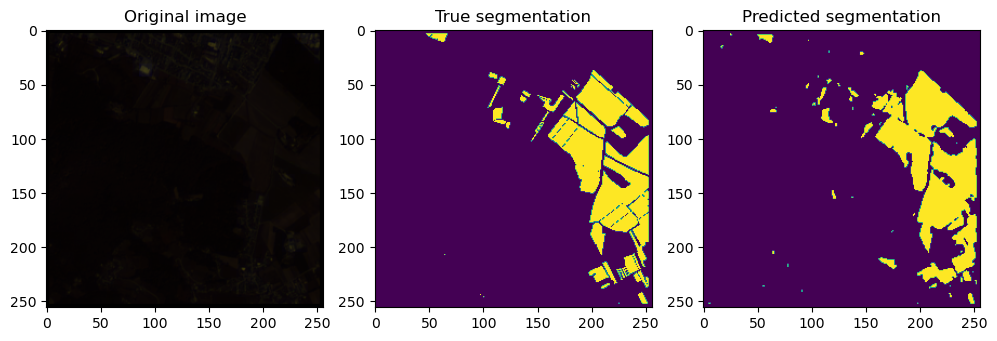

In [47]:
# Comparing the results
img_index = 1
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title('Original image')
plt.imshow(X_test[img_index, :, :, 2::-1])
plt.subplot(1, 3, 2)
plt.title('True segmentation')
plt.imshow(Y_test[img_index, :, :])
plt.subplot(1, 3, 3)
plt.title('Predicted segmentation')
plt.imshow(test_pred[img_index, :, :])
plt.tight_layout()
plt.show()

In [48]:
# Saving the model
model.save('./models/cultivated_recognition')

INFO:tensorflow:Assets written to: ./models/cultivated_recognition\assets


INFO:tensorflow:Assets written to: ./models/cultivated_recognition\assets


**[TODO]** Convert model to TFLite with 8-bit weight quantization 

In [5]:
converter = tf.lite.TFLiteConverter.from_saved_model('./models/cultivated_recognition')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converted_model = converter.convert()
with open('./tfl_cultivated_recognition.tflite', 'wb') as f:
    f.write(converted_model)

**[TODO]** Test the accuracy of the quantized model by writing your own "evaluate" function. Remember that TFLite interpreter can only process one sample at a time, not a batch.

In [6]:
def tflite_evaluate(interpreter, images_data, images_labels):
    N = images_data.shape[0]
    Npx = images_data.shape[1] * images_data.shape[2]
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    mse = []
    accuracy = 0
    for i in range(N):
        # Obtaining single data from input dataset
        test_data = images_data[i:(i + 1)]
        test_label = images_labels[i:(i + 1)]
        # Feeding data into the input tensor
        interpreter.set_tensor(input_index, test_data)
        # Running the model
        interpreter.invoke()
        out_tensor = interpreter.get_tensor(output_index)
        prediction_oh = out_tensor[:, :, :, 1:2]
        prediction = np.argmax(out_tensor, axis=-1)
        # Computing MSE of i-th image and hit or miss
        err = np.power(test_label - prediction_oh, 2)
        pred_err = test_label[:, :, :, 0] - prediction
        acc = np.count_nonzero(pred_err == 0) / Npx
        print(f'Prediction #{i + 1}: Loss = {np.sum(err)}; Accuracy = {acc}')
        # Computing overall score
        mse.append(err)
        accuracy += acc
    return [np.mean(mse), accuracy / N]

In [ ]:
# Evaluating the TFLite model
interpreter = tf.lite.Interpreter(model_content=converted_model)
interpreter.allocate_tensors()
e_MSE, accuracy = tflite_evaluate(interpreter, X_test, Y_test)
print(f'Overall MSE = {e_MSE}; Overall accuracy = {accuracy}')

**[TODO]** Finetune the Keras model using quantization-aware training and measure the accuracy on the test set after actually quantizing it 

In [ ]:
# Importing the model into a new quantization-aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model)
quant_aware_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [ ]:
quant_aware_model.fit(X_train, Y_train, batch_size=8, epochs=50)

In [ ]:
# Converting the new model into a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_aware_model = converter.convert()

In [ ]:
# Evaluating the TFLite model
interpreter = tf.lite.Interpreter(model_content=converted_model)
interpreter.allocate_tensors()
e_MSE = tflite_evaluate(interpreter, X_test, Y_test)
print(e_MSE)